In [1]:
import numpy as np
from astropy import table
from astropy import units as u

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib as mpl
mpl.rc('text', usetex=False)

In [1]:
#Comment

# Huntsman Telephoto Array SNR calculations

## Introduction

The Huntsman Telephoto Array is a joint Macquarie University/Australian Astronomical Observatory project to perform astronomical research through novel use of commercial off the shelf (COTS) imaging equipment.  The project was inspired by the [Dragonfly Telephoto Array](http://www.dunlap.utoronto.ca/instrumentation/dragonfly/).

This notebook contains signal to noise calculations for various possible Huntsman Telephoto Array configurations, intended to compare figures of merit for different equipment options under both the LSB imaging and GW event follow up science cases.


## Image sensor options

Most specifications here come from the corresponding Finger Lakes Instrumentation (FLI) [Microline camera specifications](http://www.flicamera.com/microline/index.html), with the exception of the KAF-8300M which uses the specifications for the [SBIG STF-8300M](https://www.sbig.com/products/cameras/stf-series/stf/stf-8300m/).  The read noise values used are for the lowest readout speed offered by FLI, which varies from camera to camera, and the dark current values are specified at various temperatures and are in some cases upper limits and in others 'typical' values.  Cost estimates are based on the retail prices at OptCorp in USD for a camera with a Grade 1 sensor.

In [3]:
USDtoAUD = 1.4
names = ["Name", "Pixels X", "Pixels Y", "Pixel size", "Read noise", "Dark current", "Peak QE", "Full well", "Cost"]
data_rows = [["KAF-8300M", 3326, 2504, 5.4, 9.3, 0.02, 0.56, 25.5e3, 3000 * USDtoAUD * 1.15],
             ["KAI-29050", 6576, 4384, 5.5, 8.0, 0.002, 0.48, 20e3, 13500 * USDtoAUD * 1.15],
             ["KAF-50100", 8176, 6132, 6.0, 11.5, 0.002, 0.62, 40.3e3, 16000 * USDtoAUD * 1.15],
             ["KAI-11002", 4008, 2672, 9.0, 9.0, 0.02, 0.49, 60e3, 8000 * USDtoAUD * 1.15],
             ["KAI-16070", 4864, 3232, 7.4, 9.0, 0.005, 0.52, 44e3, 13600 * USDtoAUD * 1.15],
             ["KAF-16803", 4096, 4096, 9.0, 10.0, 0.03, 0.60, 100e3, 10500*  USDtoAUD * 1.15]]
image_sensors = table.Table(rows=data_rows, names=names)
image_sensors['Pixel size'].unit = u.micron
image_sensors['Read noise'].unit = u.electron
image_sensors['Dark current'].unit = u.electron / (u.pixel * u.second)
image_sensors['Full well'].unit = u.electron
image_sensors['Cost'].unit = 'AUD'
image_sensors.pprint(max_width=100, show_dtype=False)
#image_sensors

   Name   Pixels X Pixels Y Pixel size Read noise    Dark current    Peak QE Full well   Cost 
                              micron    electron  electron / (pix s)          electron   AUD  
--------- -------- -------- ---------- ---------- ------------------ ------- --------- -------
KAF-8300M     3326     2504        5.4        9.3               0.02    0.56   25500.0  4830.0
KAI-29050     6576     4384        5.5        8.0              0.002    0.48   20000.0 21735.0
KAF-50100     8176     6132        6.0       11.5              0.002    0.62   40300.0 25760.0
KAI-11002     4008     2672        9.0        9.0               0.02    0.49   60000.0 12880.0
KAI-16070     4864     3232        7.4        9.0              0.005    0.52   44000.0 21896.0
KAF-16803     4096     4096        9.0       10.0               0.03     0.6  100000.0 16905.0


### Quantum efficiency

Absolute quantum efficiency data for each image sensor obtained by using [WebPlotDigitizer](http://arohatgi.info/WebPlotDigitizer/) on QE plots from the FLI [Microline camera spec sheets](http://www.flicamera.com/microline/index.html).

In [4]:
ns = ('Wavelength', 'QE')
QE_data = {'KAF-8300M':table.Table.read("ML8300M_QE.csv", names=ns, data_start=0),
           'KAI-29050':table.Table.read("ML29050_QE.csv", names=ns, data_start=0),
           'KAF-50100':table.Table.read("ML50100_QE.csv", names=ns, data_start=0),
           'KAI-11002':table.Table.read("ML11002_QE.csv", names=ns, data_start=0),
           'KAI-16070':table.Table.read("ML16070_QE.csv", names=ns, data_start=0),
           'KAF-16803':table.Table.read("ML16803_QE.csv", names=ns, data_start=0)}

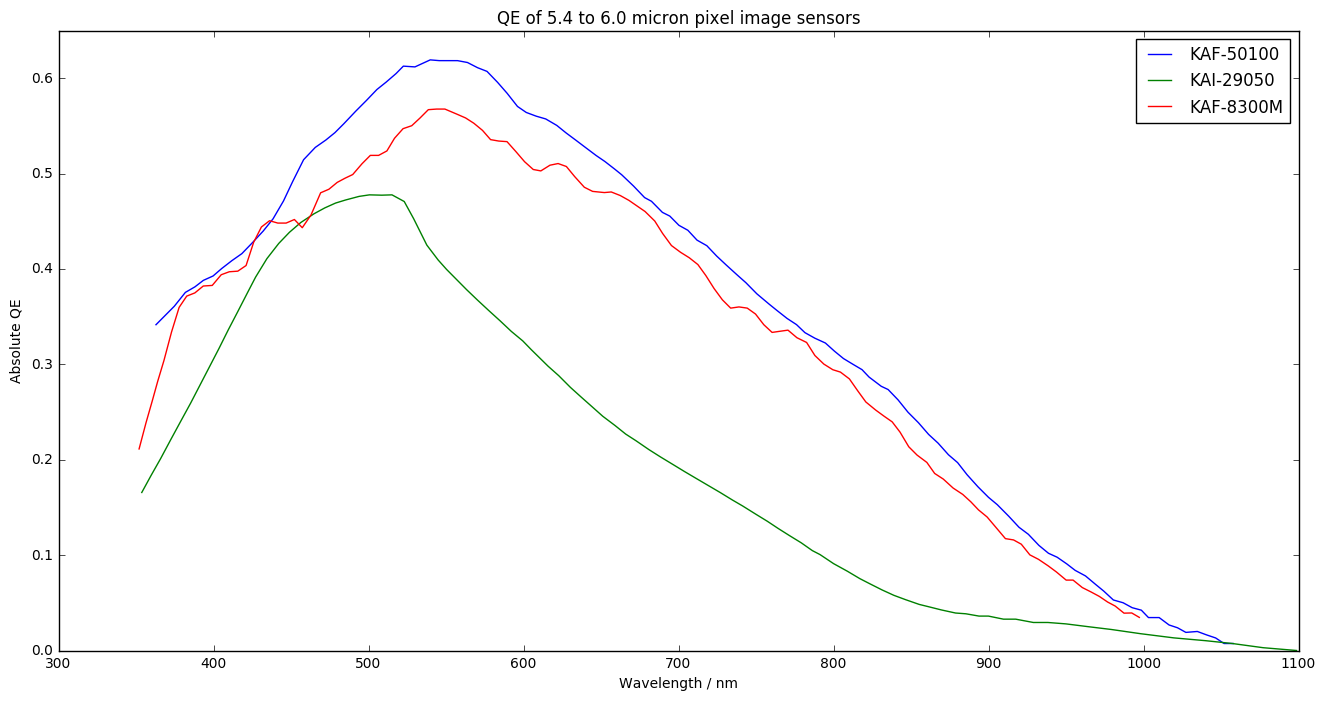

In [5]:
for name in ('KAF-50100', 'KAI-29050', 'KAF-8300M'):
    data = QE_data[name]
    plt.plot(data['Wavelength'], data['QE'], label=name)
plt.xlim(300,1100)
plt.ylim(0,0.65)
plt.xlabel('Wavelength / {}'.format(u.nanometer))
plt.ylabel('Absolute QE')
plt.title('QE of 5.4 to 6.0 micron pixel image sensors')
plt.legend(loc='best')
plt.gcf().set_size_inches(16,8)
plt.savefig('QEs_small.png')

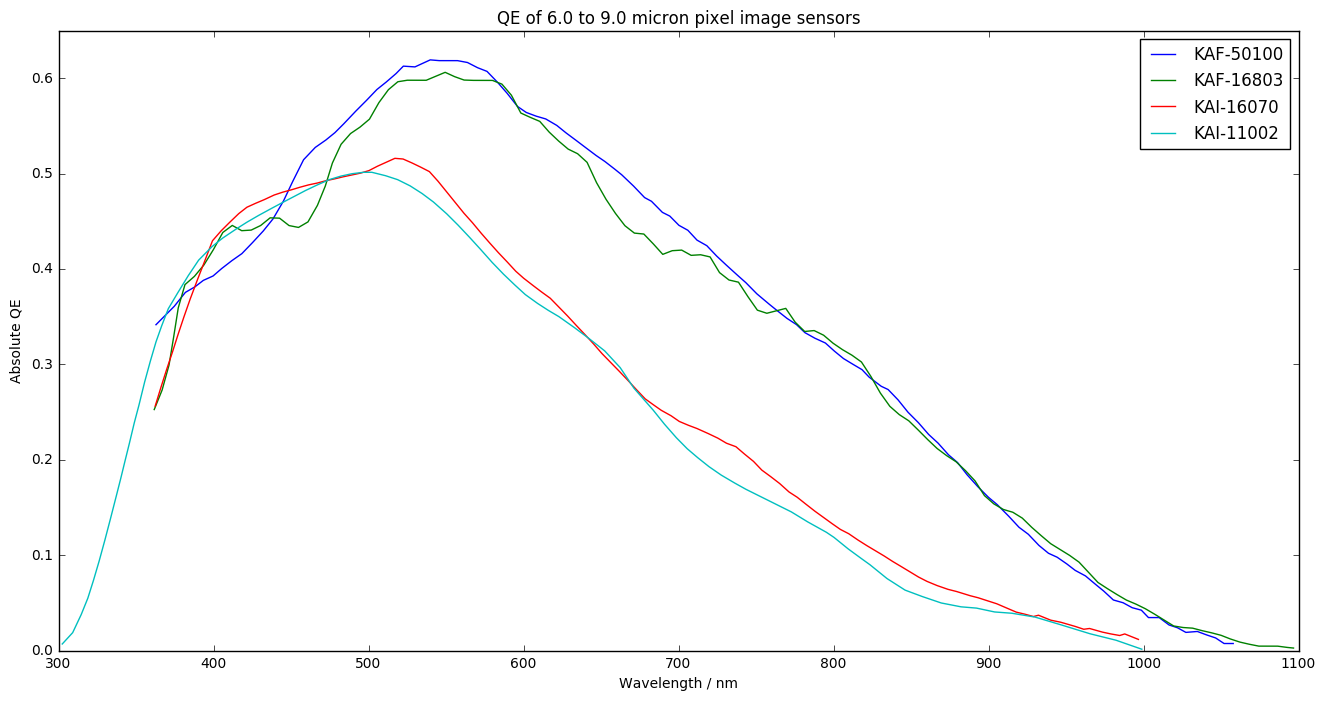

In [6]:
for name in ('KAF-50100', 'KAF-16803', 'KAI-16070', 'KAI-11002'):
    data = QE_data[name]
    plt.plot(data['Wavelength'], data['QE'], label=name)
plt.xlim(300,1100)
plt.ylim(0,0.65)
plt.title('QE of 6.0 to 9.0 micron pixel image sensors')
plt.xlabel('Wavelength / {}'.format(u.nanometer))
plt.ylabel('Absolute QE')
plt.legend(loc='best')
plt.gcf().set_size_inches(16,8)
plt.savefig('Qes_big.png')

### Band pass effective quantum efficiency

The effective QE for a given band pass is given by a weighted average of the image sensor QE over the band pass, where the QE is weighted by both the band pass filter transmission function and the spectrum of the light source in terms of photon flux, i.e. 

$$ \langle\rm{QE}\rangle = \frac{\int \Gamma_\lambda.\tau.\rm{QE}.d\lambda }{\int{ \Gamma_\lambda . \tau. d\lambda}} = \frac{\int \lambda F_\lambda.\tau.\rm{QE}.d\lambda }{\int{ \lambda F_\lambda . \tau. d\lambda}} = \frac{\int \frac{1}{\lambda}F_\nu.\tau.\rm{QE}.d\lambda }{\int{ \frac{1}{\lambda}F_\nu . \tau. d\lambda}}$$

where $\Gamma_\lambda$ is the photon flux per unit wavelength, $F_\lambda$ is the energy flux per unit wavelength and $F_\nu$ is the energy flux per unit frequency.

The effective band pass QE depends on the source spectrum so is ill-defined in the general case.  We will consider three versions of a 'flat' spectrum: constant $F_\nu$, constant $\Gamma_\lambda$ and constant $F_\lambda$.

The Huntsman Telephoto Array plans to use Sloan type [g' and r' band filters from Astrodon](http://astrodon.com/sloan.html), and possibly [Baader Planetarium f/2 Highspeed H-$\alpha$ filters](http://www.baader-planetarium.de/sektion/s43f/s43f.htm) during bright time.  For these purposes the transmission functions of the g' and r' band filters can be well approximated as top hat functions spanning 401-550 nm and 562-695 nm respectively, while the H-$\alpha$ filter can be considered essentially monochromatic at 656 nm.

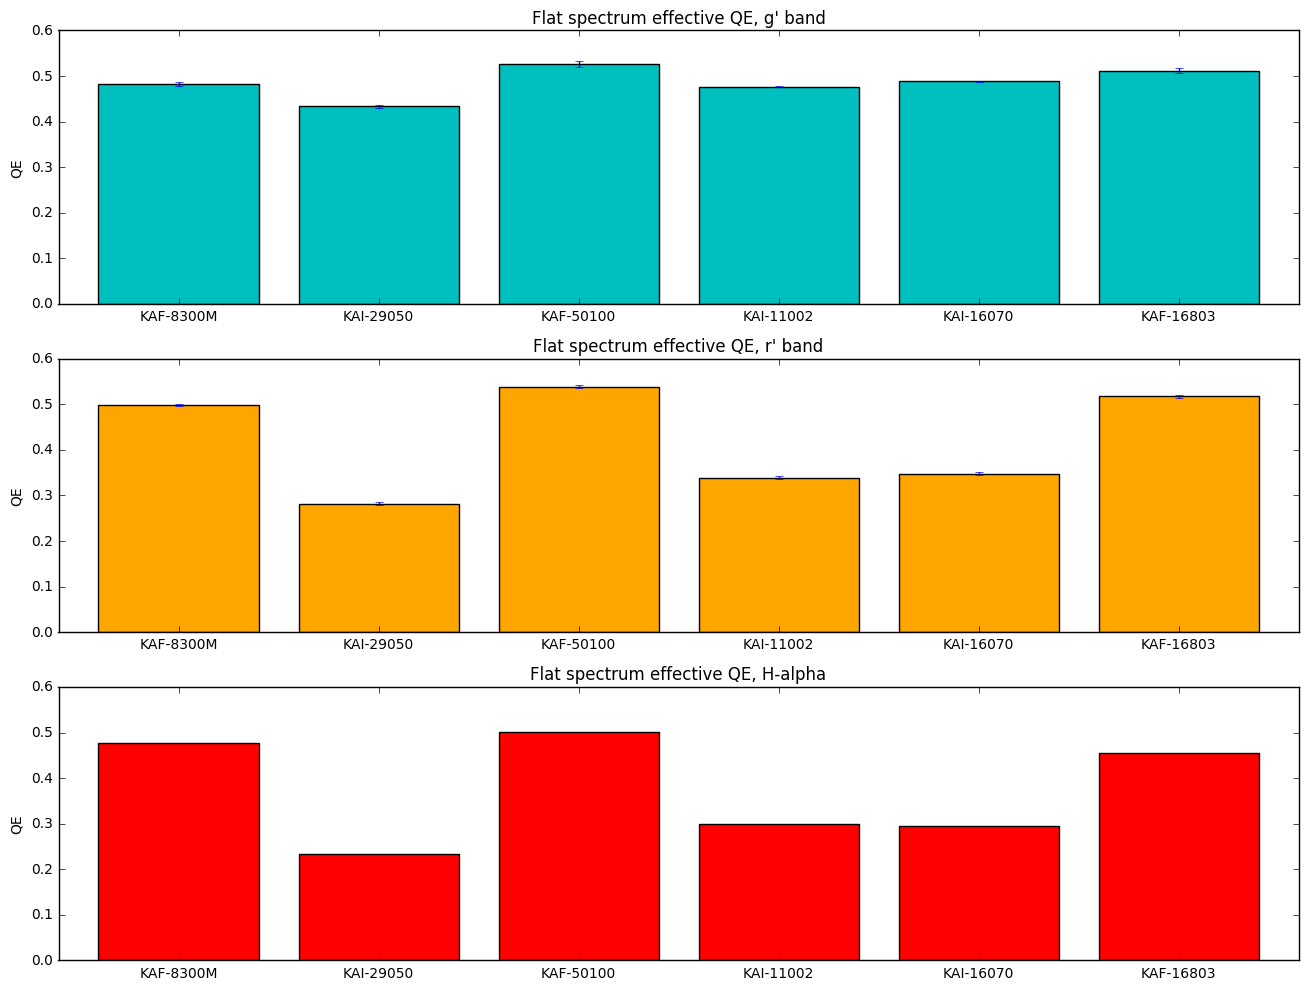

In [7]:
def bpeqe(data_table, lambda_min, lambda_max, index):
    # Wavelength values spanning filter band pass at 1 nm interval
    waves = np.arange(lambda_min, lambda_max, 1.0)
    # Interpolate QE data to wavelength values spanning the band
    qes = np.interp(waves, data_table['Wavelength'], data_table['QE'])
    # Numerical integration to calculate band pass effective QE
    return np.trapz(qes * waves**index, x=waves) / np.trapz(waves**index, x=waves)

def flat_bpeqe(QE_data, filter):
    # Calculate bandpass effective QE for 3 types of 'flat' spectrum and sort
    q = sorted((bpeqe(QE_data, filter[0], filter[1], -1), 
                bpeqe(QE_data, filter[0], filter[1], 0), 
                bpeqe(QE_data, filter[0], filter[1], 1)))
    # Return middle value and difference from other two
    return q[1], (q[1] - q[0], q[2] - q[1])

g = (401, 550) # Astrodon Gen 2 g'
r = (563, 695) # Astrodon Gen 2 r'
Ha = (654, 669) # Nominal 5 nm H-alpha

g_QEs = np.empty(len(image_sensors))
g_QE_errors = np.empty((2,len(image_sensors)))
r_QEs = np.empty_like(g_QEs)
r_QE_errors = np.empty_like(g_QE_errors)
Ha_QEs = []

for i, name in enumerate(image_sensors['Name']):
    g_QEs[i], g_QE_errors[:, i] = flat_bpeqe(QE_data[name], g)
    r_QEs[i], r_QE_errors[:, i] = flat_bpeqe(QE_data[name], r)
    Ha_QEs.append(bpeqe(QE_data[name], Ha[0], Ha[1], 0))

ls = range(len(image_sensors))

plt.subplot(3,1,1)
plt.bar(ls, g_QEs, yerr=g_QE_errors, align='center', width=0.8, color='c')
plt.xticks(ls, image_sensors['Name'])
plt.xlim(-0.6,5.6)
plt.ylabel('QE')
plt.title("Flat spectrum effective QE, g' band")
plt.subplot(3,1,2)
plt.bar(ls, r_QEs, yerr=r_QE_errors, align='center', width=0.8, color='orange')
plt.xticks(ls, image_sensors['Name'])
plt.xlim(-0.6,5.6)
plt.ylabel('QE')
plt.title("Flat spectrum effective QE, r' band")
plt.subplot(3,1,3)
plt.bar(ls, Ha_QEs, align='center', width=0.8, color='r')
plt.xticks(ls, image_sensors['Name'])
plt.xlim(-0.6,5.6)
plt.ylabel('QE')
plt.title('Flat spectrum effective QE, H-alpha')
plt.gcf().set_size_inches(16,12)
plt.savefig('bpeqes.png')

All of the image sensors considered have similar effective QE for the g' band however at longer wavelengths the 'full frame' image sensors have a considerable QE advantage over the interline CCDs.  For the r' band this amounts to almost a factor of two difference, with the KAI-29050 performing particularly badly.  At H-$\alpha$ wavelengths the difference is even larger.  While there are some advantages to the interline CCD architecture (e.g. shutterless operation, very short exposures) it seems clear that the full frame CCDs should be preferred.


## Optics

### Requirements

The primary science goals of the Huntsman Telephoto Array are focussed on low surface brightness (LSB) broad band imaging, i.e. the detection of continuum emission from faint, extended objects such as dwarf galaxies, stellar streams/tails/shells and the outermost regions of galactic discs.  This science case calls for the Huntsman Telephoto Array to image a field of $\sim2^\circ$ in two bands (g' and r') to the greatest depth possible, but only requires modest spatial resolution ($\sim 3''/$pixel).  Achieving the highest possible sensitivity to diffuse extended emission requires the minimisation of systematic errors, in particular those due to scattering, diffraction and internal reflections of light.

The gravitional wave event EM counterpart science case requires rapid imaging of large ares of sky in order to locate the optical afterglow of the event.  The event positions from the gravitational wave detectors are expected to have elongated error ellipse covering 10s or even, initially, 100s of square degrees of sky and the optical afterglow is expected to fade on timescales of minutes to hours.  Consequently both the field of view and total aperture area of the instrument should be as large as possible in order to search the error ellipse to a suitable depth as quickly as possible.

### Canon EF 400mm f/2.8L IS II USM

The [Canon EF 400mm f/2.8L IS II USM camera lens](http://www.canon.com.au/en-AU/EOS-Professional/Product-Range/Lenses/EF-Super-Telephoto/EF400mm-f28L-IS-II-USM-Lens) employed by the [Dragonfly Telephoto Array](http://www.dunlap.utoronto.ca/instrumentation/dragonfly/) and by the Huntsman Eye prototype is a good match for all of the requirements.  The focal length is a reasonable match to small pixel COTS CCD cameras, the aperture is relatively large (143 mm) and the low weight of the lens (< 5 kg) makes it possible to mount an array of at least 10 on a single [Software Bisque Paramount ME II telescope mount](http://www.bisque.com/sc/pages/ParamountMEII.aspx) without exceeding the mount's payload mass limit.

The Dragonfly team argue that the unobscured aperture, fully transmissive optics and high performance optical coatings of the Canon camera lenses used by the Dragonfly Telephoto Array gives it an advantage over conventional telescopes for observations of this kind ([Abraham & Van Dokkum 2014](http://arxiv.org/abs/1401.5473)) due to unusually low levels of diffraction, scattering and internal reflections and there is some evidence to support this view (e.g. [Sandin 2014](http://adslabs.org/adsabs/abs/2014A&A...567A..97S/)). Several papers on results from the Dragonfly Telephoto Array have already been published (e.g. [van Dokkum et al 2014](http://adslabs.org/adsabs/abs/2014ApJ...782L..24V/),  [Merrit et al 2014](http://adslabs.org/adsabs/abs/2014ApJ...787L..37M/)) with the highlight so far being the discovery of a new class of 'ultra-diffuse galaxies' (UDGs) in the Coma cluster, [van Dokkum et al 2015](http://arxiv.org/abs/1410.8141).

### AF-S NIKKOR 400mm f2.8E FL ED VR

The Nikon [AF-S NIKKOR 400mm f2.8E FL ED VR camera lens](http://www.nikon.com.au/en_AU/product/nikkor-lenses/fx-format/single-focal-length/telephoto/af-s-nikkor-400mm-f2-8e-fl-ed-vr) has near identical specifications, features and price to the Canon EF 400mm f/2.8L IS II USM.  The previous iteration of this lens has been used for astronomical research, for example the [ASAS-SN supernovae survey](http://www.astronomy.ohio-state.edu/~assassin/index.shtml).

### Celestron RASA

The Celestron Rowe-Ackermann Schmidt Astrograph (RASA) is an 11 inch f/2.2 Schmidt camera derivative. The combination of large aperture, relatively short focal length and low cost make it an attractive potential alternative to the camera lenses however as a catadioptric telescope it has both a mirror and a central obstruction which the Dragonfly team have argued cause signficant problems for LSB imaging due to increased scattering and diffraction respectively.  Somewhat mitigating these objections are the facts that the RASA has a closed tube design which protects the mirror from dust contamination and the prime focus corrector is mounted in the corrector plate and so there is no spider to induce diffraction spikes.  We also note the LSB brightness imaging reported in [Duc et al 2014](http://arxiv.org/abs/1410.0981v1) (Figure 7 and accompanying text), whihc was performed with a 12" Ritchey-Chretien astrograph.  This telescope would have two mirror surfaces exposed to the environment, a large central obstruction and spider. Duc et al attribute the LSB imaging success of amateurs to lower internal reflections due to simpler optics.


In [8]:
(5.4 * u.micron * u.radian / (7.9073e-4 * u.degree).to(u.radian)).to(u.mm)

<Quantity 391.28047420819314 mm>

In [9]:
names = ["Name", "Focal length", "Aperture", "Central obstruction", "Max FoV X", "Max FoV Y", "Cost"]
data_rows = [["Canon", 391.0, 391/2.8, 0.0, ((36/391.0 * u.radian).to(u.degree)).value, 
              ((24/391.0 * u.radian).to(u.degree)).value, 12160], # Real focal length from measured pixel scale
             ["Nikon", 378.0, 378/2.8, 0.0, ((36/378.0 * u.radian).to(u.degree)).value, 
              ((24/391.0 * u.radian).to(u.degree)).value, 12400], # Real focal length from DxOmark tests
#             ["RASA", 620.0, 279.0, 114.0, 3500 * USDtoAUD * 1.15]] # Central obstruction telescope only/QHYCCD
             ["RASA", 620.0, 279.0, 129.0, 2**-0.5*((70/620 * u.radian).to(u.degree)).value, 
              2**-0.5*((70/620 * u.radian).to(u.degree)).value, 3500 * USDtoAUD * 1.15]] # Central obstruction with FLI Microline
optics = table.Table(rows=data_rows, names=names)
optics['Focal length'].unit = u.mm
optics['Aperture'].unit = u.mm
optics['Central obstruction'].unit = u.mm
optics['Max FoV X'].unit = u.degree
optics['Max FoV Y'].unit = u.degree
optics['Cost'].unit = 'AUD'
optics['Aperture area'] = np.pi * ((optics['Aperture']).to(u.m)**2 - (optics['Central obstruction']).to(u.m)**2) / 4.0
optics['Aperture area'].unit = u.m**2
optics.pprint(max_width=200, show_dtype=False)
#optics

 Name Focal length    Aperture   Central obstruction   Max FoV X     Max FoV Y     Cost   Aperture area 
           mm            mm               mm              deg           deg        AUD          m2      
----- ------------ ------------- ------------------- ------------- ------------- ------- ---------------
Canon        391.0 139.642857143                 0.0 5.27531473778 3.51687649185 12160.0 0.0153153643646
Nikon        378.0         135.0                 0.0 5.45674090601 3.51687649185 12400.0 0.0143138815279
 RASA        620.0         279.0               129.0 4.57418773531 4.57418773531  5635.0 0.0480663675999


In [10]:
fixed_cost = 5000 # Adaptor, filters, structure

In [11]:
canon = table.Table([image_sensors['Name'], 
                     (image_sensors['Pixel size'].to(u.mm) / (optics[0]['Focal length'] * u.mm)  * u.radian).to(u.arcsecond)], 
                    names=['Image sensor', 'Pixel scale'])
canon['FoV X'] = (canon['Pixel scale'] * image_sensors['Pixels X']).to(u.degree)
canon['FoV X'] = np.where(canon['FoV X'] < optics[0]['Max FoV X'], canon['FoV X'], optics[0]['Max FoV X'])
canon['FoV Y'] = (canon['Pixel scale'] * image_sensors['Pixels Y']).to(u.degree)
canon['FoV Y'] = np.where(canon['FoV Y'] < optics[0]['Max FoV Y'], canon['FoV Y'], optics[0]['Max FoV Y'])
canon['FoV area'] = canon['FoV X'] * canon['FoV Y']
canon['FoV area'].unit = u.degree**2
canon['AOmega'] = optics[0]['Aperture area'] * u.m**2 * canon['FoV area']
canon['Cost'] = optics[0]['Cost'] + image_sensors['Cost'] + fixed_cost
canon['AOmega/$100000'] = canon['AOmega'] / canon['Cost'] * 100000.0
canon.pprint(max_width=200, show_dtype=False)

Image sensor  Pixel scale      FoV X         FoV Y        FoV area        AOmega       Cost  AOmega/$100000
                 arcsec         deg           deg           deg2         deg2 m2       AUD      deg2 m2    
------------ ------------- ------------- ------------- ------------- --------------- ------- --------------
   KAF-8300M  2.8486699584 2.63185452268 1.98140821551 5.21477817326 0.0798662278039 21990.0 0.363193396107
   KAI-29050 2.90142310578 5.27531473778 3.51687649185 18.5526303884   0.28414029432 38895.0 0.730531673274
   KAF-50100 3.16518884267 5.27531473778 3.51687649185 18.5526303884   0.28414029432 42920.0 0.662023052936
   KAI-11002   4.747783264 5.27531473778 3.51687649185 18.5526303884   0.28414029432 30040.0   0.9458731502
   KAI-16070 3.90373290596 5.27437690405 3.50468465335 18.4850277916  0.283104935918 39056.0 0.724869254193
   KAF-16803   4.747783264 5.27531473778 3.51687649185 18.5526303884   0.28414029432 34065.0 0.834112121885


In [12]:
rasa = table.Table([image_sensors['Name'], 
                    (image_sensors['Pixel size'].to(u.mm) / (optics[2]['Focal length'] * u.mm)  * u.radian).to(u.arcsecond)], 
                    names=['Image sensor', 'Pixel scale'])
rasa['FoV X'] = (rasa['Pixel scale'] * image_sensors['Pixels X']).to(u.degree)
rasa['FoV Y'] = (rasa['Pixel scale'] * image_sensors['Pixels Y']).to(u.degree)
rasa['FoV area'] = rasa['FoV X'] * rasa['FoV Y']
rasa['FoV area'].unit = u.degree**2
rasa['AOmega'] = optics[2]['Aperture area'] * rasa['FoV area'] * u.m**2
rasa['Cost'] = optics[2]['Cost'] + image_sensors['Cost'] + fixed_cost
rasa['AOmega/$100000'] = rasa['AOmega'] / rasa['Cost'] * 100000.0
rasa.pprint(max_width=200, show_dtype=False)

Image sensor  Pixel scale      FoV X         FoV Y        FoV area        AOmega       Cost  AOmega/$100000
                 arcsec         deg           deg           deg2         deg2 m2       AUD      deg2 m2    
------------ ------------- ------------- ------------- ------------- --------------- ------- --------------
   KAF-8300M 1.79649992538 1.65976631995 1.24956550365 2.07398673753 0.0996890089234 15465.0 0.644610468305
   KAI-29050 1.82976844251 3.34237702166 2.22825134777 7.44765610328  0.357981776018 32370.0   1.1059060118
   KAF-50100  1.9961110282 4.53338993515 3.40004245136 15.4137182281  0.740881446433 36395.0  2.03566821386
   KAI-11002  2.9941665423 3.33350541709 2.22233694473 7.40817224385  0.356083930316 23515.0  1.51428420292
   KAI-16070 2.46187026811 3.32626027336 2.21021241848 7.35174176328  0.353371522093 32531.0  1.08626086531
   KAF-16803  2.9941665423 3.40669615479 3.40669615479 11.6055786911  0.557838011575 27540.0  2.02555559758


In [16]:
from astropy.io import fits
from astropy.wcs import WCS
from matplotlib.patches import Rectangle

In [17]:
def drawFoV(x0, y0, row, pix_scale, color):
    lx = x0 - row['FoV X'] / (2 * pix_scale)
    ly = y0 - row['FoV Y'] / (2 * pix_scale)
    wx =  row['FoV X'] / pix_scale
    wy =  row['FoV Y'] / pix_scale
    print(lx, ly, wx, wy)
    return Rectangle((lx, ly), wx, wy, edgecolor=color, facecolor='none')

586.294368001 441.810311928 287.411263999 216.379376143
941.955037083 357.970024722 576.089925834 384.059950556
982.465928448 864.349446336 495.068143103 371.301107328
543.986138012 863.986138012 372.027723976 372.027723976


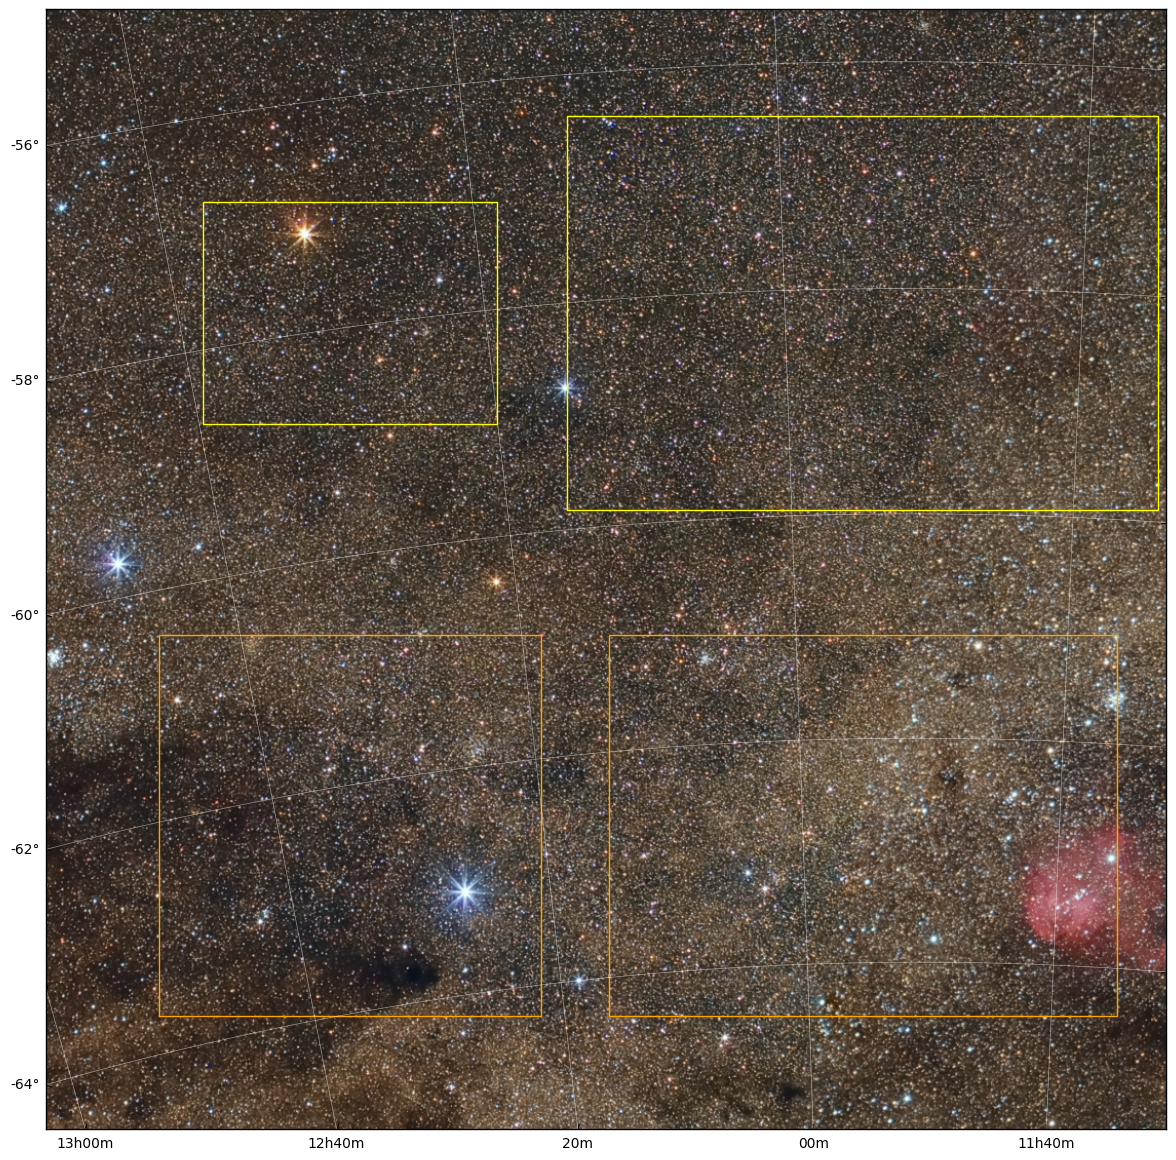

In [65]:
hdu = fits.open('wcs.fits')[0]
wcs = WCS(header=hdu.header, naxis=2)
pix_scale = np.mean((np.linalg.norm(np.dot(wcs.pixel_scale_matrix, [1, 0])), 
                     np.linalg.norm(np.dot(wcs.pixel_scale_matrix, [0, 1]))))
x0, y0 = 980, 800
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], projection=wcs)
ax.imshow(plt.imread('Crux_Carina_Musca_hires.JPG'))
ax.set_xlim(x0 - 5/pix_scale, x0 + 5/pix_scale)
ax.set_ylim(y0 + 5/pix_scale, y0 - 5/pix_scale)
ra = ax.coords['ra']
dec = ax.coords['dec']
ra.set_major_formatter('hh:mm')
dec.set_major_formatter('dd')
ax.coords.grid(color='white', alpha=0.5, linestyle='solid')

ax.add_patch(drawFoV(x0-250, y0-250, canon[0], pix_scale, 'yellow'))
ax.add_patch(drawFoV(x0+250, y0-250, canon[1], pix_scale, 'yellow'))

ax.add_patch(drawFoV(x0+250, y0+250, rasa[2], pix_scale, 'orange'))
ax.add_patch(drawFoV(x0-250, y0+250, rasa[-1], pix_scale, 'orange'))

fig.set_size_inches(16,14)

fig.savefig('FoVs.png')

In [23]:
#!/usr/bin/env python
from __future__ import absolute_import, division, print_function, unicode_literals # Python 2 & 3 compatibility
import math
   
# Sky surface brightness, Gunn g & r bands
sky_mu = {'g':22.5, 'r':21.5} # AB mag/arcsec^2

# SBIG STD-8300M properties
dark_current = 0.04 # e/pixel/second
read_noise = 10.0 # e/pixel/read

# Number of photons/second/pixel at the top of atmosphere 
# that corresponds to 0 AB mag/arcsec^2, Gunn g & r bands.
gamma0 = {'g':1.79e9, 'r':1.16e9}

# Fractional overall system efficiency, Gunn g & r bands
efficiency = {'g':0.34, 'r':0.35}

def snr(sci_mu, band, total_exp_time, sub_exp_time=600, sky=sky_mu, binning=1, N=1, round_up=True):
    
    # Science count rates, uses equations 8 & 9 from Dragonfly paper to convert AB mag/arcsec^2 to e/pixel/s
    rate_sci = gamma0[band] * N * efficiency[band] * 10**(-0.4 * sci_mu) # e/pixel/second
    
    # Sky count rates, uses equations 8 & 9 from Dragonfly paper to convert AB mag/arcsec^2 to e/pixel/s
    rate_sky =  gamma0[band] * N * efficiency[band] * 10**(-0.4 * sky_mu[band]) # e/pixel/second
    
    # Number of sub-exposures
    number_subs = int(math.ceil(total_exp_time/sub_exp_time))
    if round_up and (total_exp_time != number_subs * sub_exp_time):
        total_exp_time = number_subs * sub_exp_time
        print('Rounding up total exposure time to next integer multiple of sub-exposure time:', total_exp_time)
    
    # Noise sources
    signal = rate_sci * total_exp_time # e/pixel
    sky_counts = rate_sky * total_exp_time # e/pixel
    dark_counts = dark_current * total_exp_time # e/pixel
    total_read_noise = math.sqrt(number_subs) * read_noise  # e/pixel
    
    noise = math.sqrt(signal + sky_counts + dark_counts + total_read_noise**2) # e/pixel
    
    s = binning * signal/noise # Binning increases signal to noise by the binning factor
    
    #print(s, signal, sky_counts, dark_counts, total_read_noise**2)
        
    return s


def etc(sci_mu, band, snr_target, sky=sky_mu, sub_exp_time=600, binning=1, N=1):
    
    # Convert target SNR per binned pixel to SNR per unbinned pixel
    snr_target /= binning
    
    # Science count rates, uses equations 8 & 9 from Dragonfly paper to convert AB mag/arcsec^2 to e/pixel/s
    rate_sci = gamma0[band] * N * efficiency[band] * 10**(-0.4 * sci_mu) # e/pixel/second
    
    # Sky count rates, uses equations 8 & 9 from Dragonfly paper to convert AB mag/arcsec^2 to e/pixel/s
    rate_sky =  gamma0[band] * N * efficiency[band] * 10**(-0.4 * sky_mu[band]) # e/pixel/second
    
    # If required total exposure time is much greater than the length of a sub-exposure then
    # all noise sources (including read noise) are proportional to t^0.5 and we can use a 
    # simplified expression to estimate total exposure time.
    total_exp_time = snr_target**2 * (rate_sci + rate_sky + dark_current + read_noise**2/sub_exp_time) / rate_sci**2
    
    # The simplified expression underestimates read noise due to fractional number of sub-exposure,
    # the effect will be neglible unless the total exposure time is very short but we can fix it anyway...
    # First round up to the next integer number of sub-exposures:
    number_subs = int(math.ceil(total_exp_time / sub_exp_time))
    # If the SNR has dropped below the target value as a result of the extra read noise add another sub
    # Note: calling snr() here is horribly inefficient as it recalculates a bunch of stuff but I don't care.
    while snr(sci_mu, band, number_subs*sub_exp_time, sub_exp_time, binning, N, round_up=False) < snr_target:
        print("Adding a sub-exposure to overcome read noise!")
        number_subs += 1
    
    return number_subs*sub_exp_time, number_subs


def limit(band, total_exp_time, snr_target, sky_mu=sky_mu, sub_exp_time=600, binning=1, N=1, round_up=True
         , enable_read_noise=True, enable_sky_noise=True, enable_dark_noise=True):
    
    # Convert target SNR per binned pixel to SNR per unbinned pixel
    snr_target /= binning
    
    # Sky count rates, uses equations 8 & 9 from Dragonfly paper to convert AB mag/arcsec^2 to e/pixel/s
    rate_sky =  gamma0[band] * N * efficiency[band] * 10**(-0.4 * sky_mu[band]) # e/pixel/second
    
    # Number of sub-exposures
    number_subs = int(math.ceil(total_exp_time/sub_exp_time))
    if round_up and (total_exp_time != number_subs * sub_exp_time):
        total_exp_time = number_subs * sub_exp_time
        print('Rounding up total exposure time to next integer multiple of sub-exposure time:', total_exp_time)
        
    # Noise sources
    sky_counts = rate_sky * total_exp_time if enable_sky_noise else 0.0 # e/pixel
    dark_counts = dark_current * total_exp_time if enable_dark_noise else 0.0 # e/pixel
    total_read_noise = math.sqrt(number_subs) * read_noise if enable_read_noise else 0.0 # e/pixel
    
    # Calculate science count rate for target signal to noise ratio
    a = total_exp_time**2
    b = -snr_target**2 * total_exp_time
    c = -snr_target**2 * (sky_counts + dark_counts + total_read_noise**2)
    rate_sci = (-b + math.sqrt(b**2 - 4*a*c))/(2*a) # e/pixel/second
    
    # Convert science count rate to surface brightness with inverse of equations 8 & 9 from Dragonfly paper
    sci_mu = -2.5 * math.log10(rate_sci / (gamma0[band] * N * efficiency[band])) # AB mag/arcsec^2
    
    return sci_mu

if __name__ == '__main__':
    snr_g, snr_r = snr(30.0, 'g', 150000), snr(30.0, 'r', 150000)
    print('g\'-band S/N =', snr_g)
    print('r\'-band S/N =', snr_r)


g'-band S/N = 0.26095504278226683
r'-band S/N = 0.14196043946490822


In [24]:
snr(26.0, 'g', 13000)

Rounding up total exposure time to next integer multiple of sub-exposure time: 13200


3.0381536605570645

In [25]:
etc(22, 'g', 5.0, sub_exp_time=60)

(120, 2)

In [26]:
limit('g', 100000, 3.0, sky_mu={'g':22.5, 'r':21.5}, sub_exp_time=300)

Rounding up total exposure time to next integer multiple of sub-exposure time: 100200


27.023816828941673

In [27]:
limit('g', 100000, 3.0, sky_mu={'g':24.0, 'r':23.0}, sub_exp_time=600)

Rounding up total exposure time to next integer multiple of sub-exposure time: 100200


27.56584693329358

In [28]:
%matplotlib inline

In [29]:
import numpy
import math
import matplotlib.pyplot as pyplot

In [30]:
ts = numpy.arange(10,1001,10)
ts

array([  10,   20,   30,   40,   50,   60,   70,   80,   90,  100,  110,
        120,  130,  140,  150,  160,  170,  180,  190,  200,  210,  220,
        230,  240,  250,  260,  270,  280,  290,  300,  310,  320,  330,
        340,  350,  360,  370,  380,  390,  400,  410,  420,  430,  440,
        450,  460,  470,  480,  490,  500,  510,  520,  530,  540,  550,
        560,  570,  580,  590,  600,  610,  620,  630,  640,  650,  660,
        670,  680,  690,  700,  710,  720,  730,  740,  750,  760,  770,
        780,  790,  800,  810,  820,  830,  840,  850,  860,  870,  880,
        890,  900,  910,  920,  930,  940,  950,  960,  970,  980,  990,
       1000])

In [31]:
lgs = [limit('g', t, 3.0, sub_exp_time=t) for t in ts]
lrs = [limit('r', t, 3.0, sub_exp_time=t) for t in ts]

lgrs = [limit('g', t, 3.0, sub_exp_time=t, enable_read_noise=False) for t in ts]
lrrs = [limit('r', t, 3.0, sub_exp_time=t, enable_read_noise=False) for t in ts]

lgds = [limit('g', t, 3.0, sub_exp_time=t, enable_dark_noise=False) for t in ts]
lrds = [limit('r', t, 3.0, sub_exp_time=t, enable_dark_noise=False) for t in ts]

lgss = [limit('g', t, 3.0, sub_exp_time=t, enable_sky_noise=False) for t in ts]
lrss = [limit('r', t, 3.0, sub_exp_time=t, enable_sky_noise=False) for t in ts]

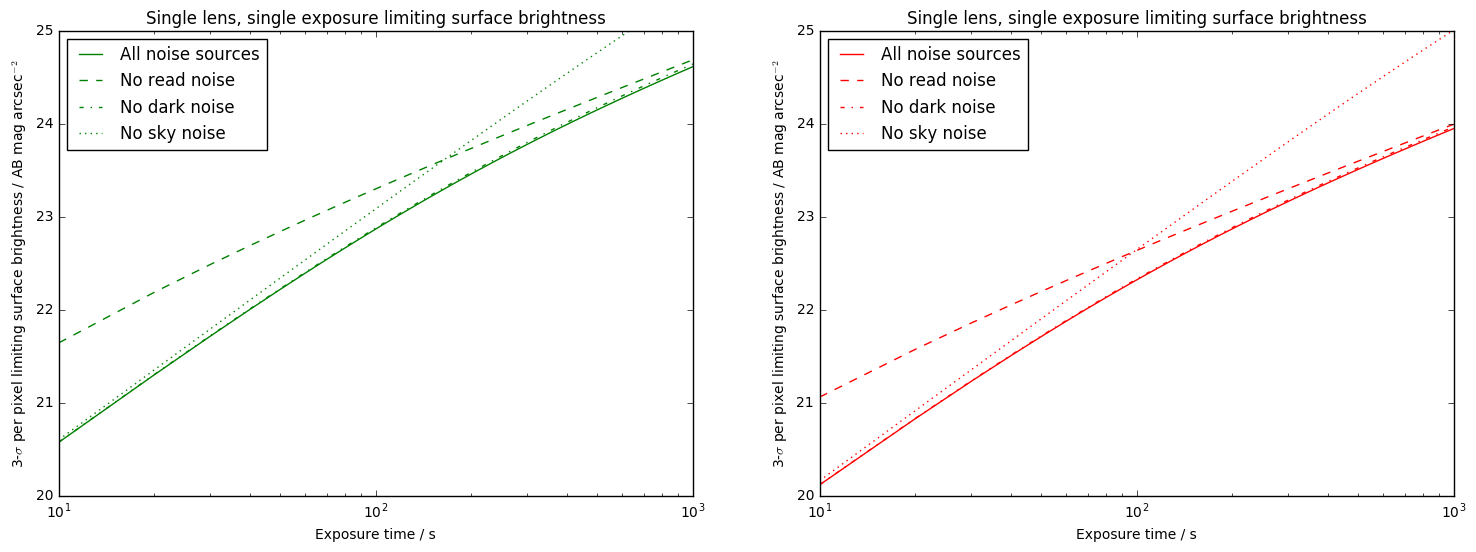

In [32]:
pyplot.subplot(1,2,1)

pyplot.semilogx(ts, lgs, 'g-', label='All noise sources')
pyplot.semilogx(ts, lgrs, 'g--', label='No read noise')
pyplot.semilogx(ts, lgds, 'g-.', label='No dark noise')
pyplot.semilogx(ts, lgss, 'g:', label='No sky noise')
pyplot.legend(loc='best')
pyplot.ylim(20,25)
pyplot.xlabel('Exposure time / s')
pyplot.ylabel('3-$\sigma$ per pixel limiting surface brightness / AB mag arcsec$^{-2}$')
pyplot.title('Single lens, single exposure limiting surface brightness')

pyplot.subplot(1,2,2)

pyplot.semilogx(ts, lrs, 'r-', label='All noise sources')
pyplot.semilogx(ts, lrrs, 'r--', label='No read noise')
pyplot.semilogx(ts, lrds, 'r-.', label='No dark noise')
pyplot.semilogx(ts, lrss, 'r:', label='No sky noise')
pyplot.legend(loc='best')
pyplot.ylim(20,25)
pyplot.xlabel('Exposure time / s')
pyplot.ylabel('3-$\sigma$ per pixel limiting surface brightness / AB mag arcsec$^{-2}$')
pyplot.title('Single lens, single exposure limiting surface brightness')

pyplot.gcf().set_size_inches(18,6)

pyplot.savefig('limit.png')

In [33]:
limit('r', 540, 3.0, sub_exp_time=60)

23.157065531393943

In [34]:
limit('r', 60, 3.0, sub_exp_time=60)

21.879653639744497

In [35]:
limit('r', 540, 3.0, sub_exp_time=60) - limit('r', 60, 3.0, sub_exp_time=60)

1.2774118916494466

In [36]:
18 - (limit('r', 540, 3.0, sub_exp_time=60) - limit('r', 60, 3.0, sub_exp_time=60))

16.722588108350553

In [37]:
18 - (limit('r', 540, 3.0, sub_exp_time=60) - limit('g', 60, 3.0, sub_exp_time=60))

17.240091133926192

In [38]:
def theta_max(F):
    return math.atan(1/(2*F))

In [39]:
def lambda_shift(theta, n_eff):
    return math.sqrt(1 - (math.sin(theta)/n_eff)**2)

In [40]:
def NB_filter(wave, wave_c, FWHM, w):
    if abs(wave - wave_c) > 0.5*(1 + w)*FWHM:
        return 0.0
    elif abs(wave - wave_c) < 0.5*(1-w)*FWHM:
        return 1.0
    else:
        return 1 - (abs(wave - wave_c) - 0.5*(1-w)*FWHM)/(w*FWHM) 

In [41]:
def fast_NB_filter(wave, wave_c, FWHM, w, F, n_eff, n_thetas):
    thetas = numpy.linspace(0, theta_max(F), n_thetas)
    num = math.fsum([NB_filter(wave/lambda_shift(theta, n_eff), wave_c, FWHM, w)*math.sin(theta) for theta in thetas])
    denom = math.fsum(math.sin(theta) for theta in thetas)
    return num/denom

In [42]:
H_a = 656.28

In [43]:
gc = (401+550) / 2.0
gf = 550 - 401.0
gw = 0.01

In [44]:
rc = (562+695) / 2.0
rf = 695 - 562.0
rw = 0.01

In [45]:
thetas = numpy.linspace(0, theta_max(2.2), 100)

In [46]:
waves = numpy.linspace(645,662,200)

In [47]:
waves2 = numpy.linspace(390, 560, 200)

In [48]:
waves3 = numpy.linspace(550, 705, 200)

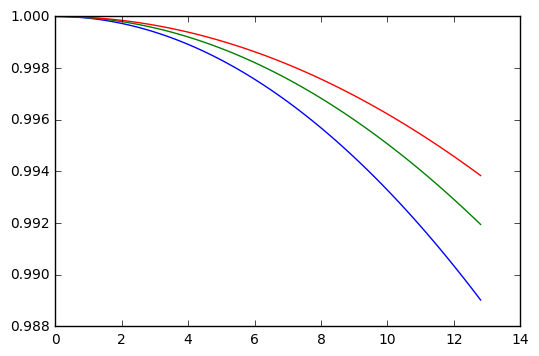

In [49]:
pyplot.plot(numpy.degrees(thetas), [lambda_shift(theta, 1.5) for theta in thetas])
pyplot.plot(numpy.degrees(thetas), [lambda_shift(theta, 1.75) for theta in thetas])
pyplot.plot(numpy.degrees(thetas), [lambda_shift(theta, 2.0) for theta in thetas])


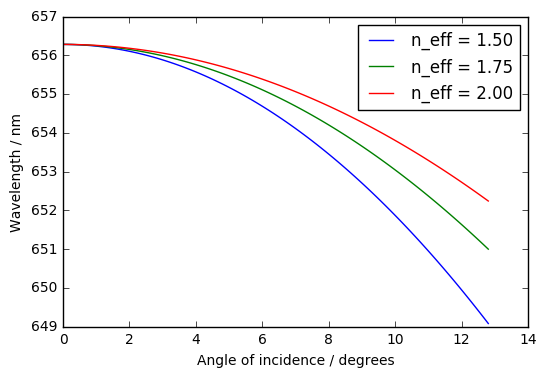

In [50]:
pyplot.plot(numpy.degrees(thetas), [H_a * lambda_shift(theta, 1.5) for theta in thetas], label='n_eff = 1.50')
pyplot.plot(numpy.degrees(thetas), [H_a * lambda_shift(theta, 1.75) for theta in thetas], label='n_eff = 1.75')
pyplot.plot(numpy.degrees(thetas), [H_a * lambda_shift(theta, 2.0) for theta in thetas], label='n_eff = 2.00')
pyplot.legend()
pyplot.xlabel('Angle of incidence / degrees')
pyplot.ylabel('Wavelength / nm')

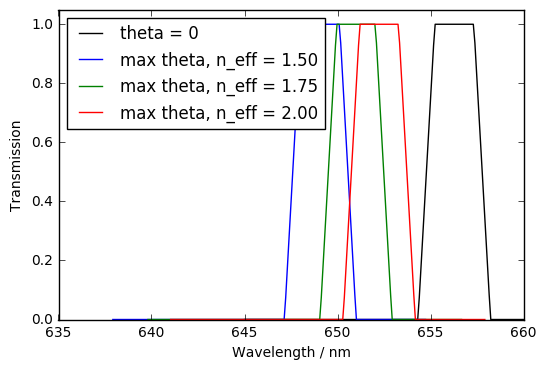

In [51]:
pyplot.plot(waves, [NB_filter(wave, H_a, 3.0, 0.3) for wave in waves], 'k', label ='theta = 0')
pyplot.plot(waves*lambda_shift(theta_max(2.2), 1.5), [NB_filter(wave, H_a, 3.0, 0.3) for wave in waves], label='max theta, n_eff = 1.50' )
pyplot.plot(waves*lambda_shift(theta_max(2.2), 1.75) , [NB_filter(wave, H_a, 3.0, 0.3) for wave in waves], label='max theta, n_eff = 1.75')
pyplot.plot(waves*lambda_shift(theta_max(2.2), 2.0) , [NB_filter(wave, H_a, 3.0, 0.3) for wave in waves], label='max theta, n_eff = 2.00')
pyplot.xlim(635,660)
pyplot.ylim(0,1.05)
pyplot.legend(loc=2)
pyplot.xlabel('Wavelength / nm')
pyplot.ylabel('Transmission')

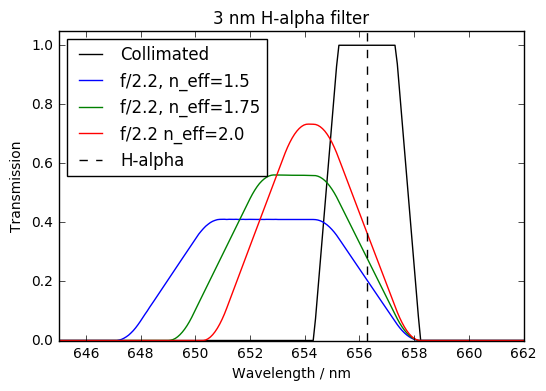

In [52]:
pyplot.plot(waves, [NB_filter(wave, H_a, 3.0, 0.3) for wave in waves], 'k', label='Collimated')
pyplot.plot(waves, [fast_NB_filter(wave, H_a, 3.0, 0.3, 2.2, 1.5, 100) for wave in waves], 'b', label='f/2.2, n_eff=1.5')
pyplot.plot(waves, [fast_NB_filter(wave, H_a, 3.0, 0.3, 2.2, 1.75, 100) for wave in waves], 'g', label='f/2.2, n_eff=1.75')
pyplot.plot(waves, [fast_NB_filter(wave, H_a, 3.0, 0.3, 2.2, 2.00, 100) for wave in waves], 'r', label='f/2.2 n_eff=2.0')
pyplot.plot([H_a, H_a], [0,1.05], 'k--', label='H-alpha')
pyplot.title('3 nm H-alpha filter')
pyplot.xlim(645,662)
pyplot.ylim(0,1.05)
pyplot.legend(loc=2)
pyplot.xlabel('Wavelength / nm')
pyplot.ylabel('Transmission')
pyplot.savefig('3nmHaf28.png')

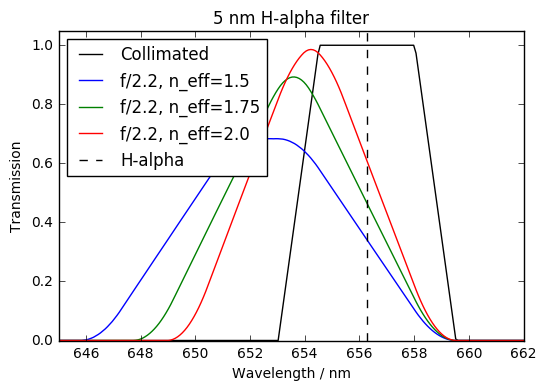

In [53]:
pyplot.plot(waves, [NB_filter(wave, H_a, 5.0, 0.3) for wave in waves], 'k', label='Collimated')
pyplot.plot(waves, [fast_NB_filter(wave, H_a, 5.0, 0.3, 2.2, 1.5, 100) for wave in waves], 'b', label='f/2.2, n_eff=1.5')
pyplot.plot(waves, [fast_NB_filter(wave, H_a, 5.0, 0.3, 2.2, 1.75, 100) for wave in waves], 'g', label='f/2.2, n_eff=1.75')
pyplot.plot(waves, [fast_NB_filter(wave, H_a, 5.0, 0.3, 2.2, 2.00, 100) for wave in waves], 'r', label='f/2.2, n_eff=2.0')
pyplot.plot([H_a, H_a], [0,1.05], 'k--', label='H-alpha')
pyplot.title('5 nm H-alpha filter')
pyplot.xlim(645,662)
pyplot.ylim(0,1.05)
pyplot.legend(loc=2)
pyplot.xlabel('Wavelength / nm')
pyplot.ylabel('Transmission')
pyplot.savefig('5nmHaf28.png')

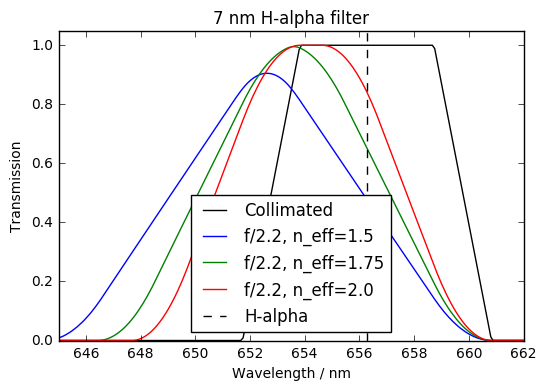

In [54]:
pyplot.plot(waves, [NB_filter(wave, H_a, 7.0, 0.3) for wave in waves], 'k', label='Collimated')
pyplot.plot(waves, [fast_NB_filter(wave, H_a, 7.0, 0.3, 2.2, 1.5, 100) for wave in waves], 'b', label='f/2.2, n_eff=1.5')
pyplot.plot(waves, [fast_NB_filter(wave, H_a, 7.0, 0.3, 2.2, 1.75, 100) for wave in waves], 'g', label='f/2.2, n_eff=1.75')
pyplot.plot(waves, [fast_NB_filter(wave, H_a, 7.0, 0.3, 2.2, 2.00, 100) for wave in waves], 'r', label='f/2.2, n_eff=2.0')
pyplot.plot([H_a, H_a], [0,1.05], 'k--', label='H-alpha')
pyplot.title('7 nm H-alpha filter')
pyplot.xlim(645,662)
pyplot.ylim(0,1.05)
pyplot.legend(loc=8)
pyplot.xlabel('Wavelength / nm')
pyplot.ylabel('Transmission')
pyplot.savefig('7nmHaf22.png')

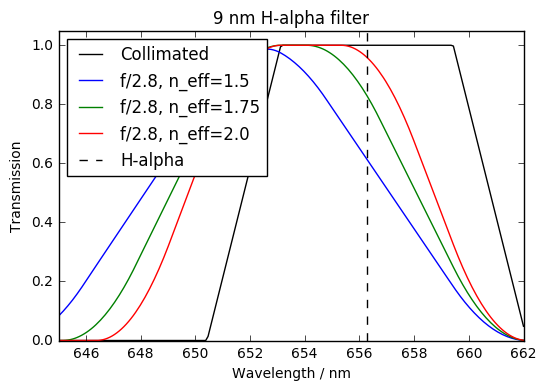

In [55]:
pyplot.plot(waves, [NB_filter(wave, H_a, 9.0, 0.3) for wave in waves], 'k', label='Collimated')
pyplot.plot(waves, [fast_NB_filter(wave, H_a, 9.0, 0.3, 2.2, 1.5, 100) for wave in waves], 'b', label='f/2.8, n_eff=1.5')
pyplot.plot(waves, [fast_NB_filter(wave, H_a, 9.0, 0.3, 2.2, 1.75, 100) for wave in waves], 'g', label='f/2.8, n_eff=1.75')
pyplot.plot(waves, [fast_NB_filter(wave, H_a, 9.0, 0.3, 2.2, 2.00, 100) for wave in waves], 'r', label='f/2.8, n_eff=2.0')
pyplot.plot([H_a, H_a], [0,1.05], 'k--', label='H-alpha')
pyplot.title('9 nm H-alpha filter')
pyplot.xlim(645,662)
pyplot.ylim(0,1.05)
pyplot.legend(loc=2)
pyplot.xlabel('Wavelength / nm')
pyplot.ylabel('Transmission')
pyplot.savefig('9nmHaf28.png')

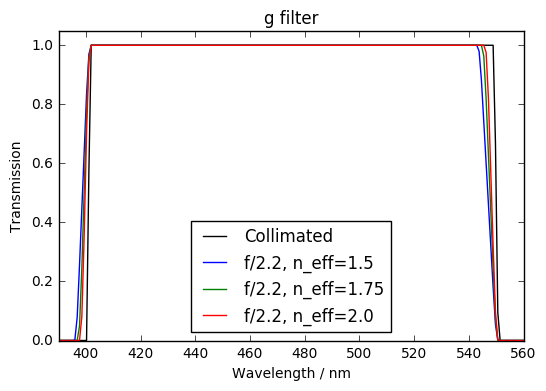

In [56]:
pyplot.plot(waves2, [NB_filter(wave, gc, gf, gw) for wave in waves2], 'k', label='Collimated')
pyplot.plot(waves2, [fast_NB_filter(wave, gc, gf, gw, 2.2, 1.5, 100) for wave in waves2], 'b', label='f/2.2, n_eff=1.5')
pyplot.plot(waves2, [fast_NB_filter(wave, gc, gf, gw, 2.2, 1.75, 100) for wave in waves2], 'g', label='f/2.2, n_eff=1.75')
pyplot.plot(waves2, [fast_NB_filter(wave, gc, gf, gw, 2.2, 2.00, 100) for wave in waves2], 'r', label='f/2.2, n_eff=2.0')
pyplot.title('g filter')
pyplot.xlim(390,560)
pyplot.ylim(0,1.05)
pyplot.legend(loc=8)
pyplot.xlabel('Wavelength / nm')
pyplot.ylabel('Transmission')
pyplot.savefig('gf22.png')

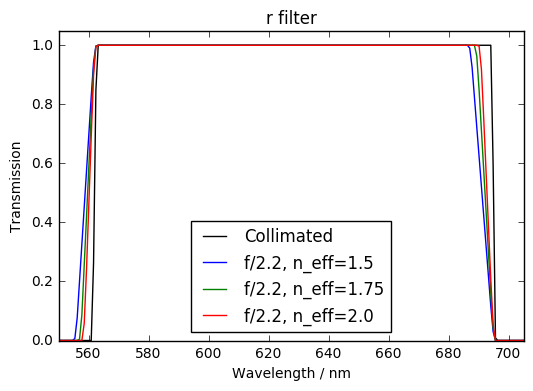

In [57]:
pyplot.plot(waves3, [NB_filter(wave, rc, rf, rw) for wave in waves3], 'k', label='Collimated')
pyplot.plot(waves3, [fast_NB_filter(wave, rc, rf, rw, 2.2, 1.5, 100) for wave in waves3], 'b', label='f/2.2, n_eff=1.5')
pyplot.plot(waves3, [fast_NB_filter(wave, rc, rf, rw, 2.2, 1.75, 100) for wave in waves3], 'g', label='f/2.2, n_eff=1.75')
pyplot.plot(waves3, [fast_NB_filter(wave, rc, rf, rw, 2.2, 2.00, 100) for wave in waves3], 'r', label='f/2.2, n_eff=2.0')
pyplot.title('r filter')
pyplot.xlim(550,705)
pyplot.ylim(0,1.05)
pyplot.legend(loc=8)
pyplot.xlabel('Wavelength / nm')
pyplot.ylabel('Transmission')
pyplot.savefig('rf22.png')

In [58]:
(5.2**2 + 3.8**2)**0.5

6.440496875241847